---

# '최동원 선수 연봉 예측 프로젝트' 분석 Process

### **Ⅰ. 데이터 수집**
&nbsp;&nbsp;&nbsp;&nbsp;**1. KBREPORT**
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1) 1983 - 1988까지 투수 데이터 (최동원 선수 포함)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2) 2015 - 2020까지 투수 데이터
<br>&nbsp;&nbsp;&nbsp;&nbsp;**2. STATIZ - 연봉 데이터 수집**
<br>
### **Ⅱ. 데이터 전처리**
&nbsp;&nbsp;&nbsp;&nbsp;**1. KBREPORT**
<br>&nbsp;&nbsp;&nbsp;&nbsp;**2. KBREPORT 데이터에 연봉 데이터 합치기**
<br>
### **Ⅲ. 데이터 매핑**
<br>

### **Ⅳ. 최동원 선수의 연봉 예측**
&nbsp;&nbsp;&nbsp;&nbsp;**1. 데이터 타입 변환**
<br>&nbsp;&nbsp;&nbsp;&nbsp;**2. 변수 탐색 - features, target**
<br>&nbsp;&nbsp;&nbsp;&nbsp;**3. model 적합**
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1) Full model
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(2) correlation -0.2 ~ 0.2인 features 제거
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(3) correlation -0.3 ~ 0.3인 features 제거
<br>&nbsp;&nbsp;&nbsp;&nbsp;**4. 모델 비교**
<br>&nbsp;&nbsp;&nbsp;&nbsp;**5. 연봉 예측하기**

---

# Ⅰ. 데이터 수집

1. 최동원의 롯데 시절 1983년부터 1988년의 데이터
2. 1983년부터 1988년 사이 투수들의 데이터 (연봉 포함)
3. 2015년부터 2020년까지의 프로야구 투수들의 데이터
<br>
※ 모든 데이터를 구할 필요는 없지만, 최동원의 선발/마무리 데이터는 필요할 수 있음

- KBReport 역대기록 > 투구기록 탭(http://www.kbreport.com/history/pitcher/main) 에는 1982년부터 2012년까지 데이터 존재
- 여기서 1983년 ~ 1988년까지의 투수 데이터 크롤링
<br>
<br>
- 선수기록 > 투구기록 탭(http://www.kbreport.com/leader/pitcher/main) 에는 2011-2022
- 여기서 2015년 - 2020년까지의 프로야구 투수 데이터 크롤링

In [1]:
import pandas as pd
import numpy as np
import time
import warnings

from time import sleep
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from tqdm import tqdm_notebook
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings(action='ignore')

## 1. KBREPORT

In [2]:
url = 'http://www.kbreport.com/history/pitcher/main'
driver = webdriver.Chrome('../driver/chromedriver.exe')
driver.get(url)

In [3]:
col_list = ['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝',
            '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR',
            'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉',
            '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4',
            'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율',
            '피출루율', 'WHIP']

In [4]:
pitcher_1983_to_1988 = pd.DataFrame(columns = col_list)
pitcher_1983_to_1988

,#,선수명,팀명,승,패,세,경기,선발,이닝,삼진/9,...,HBP,폭투,보크,PK,삼진%,볼넷%,삼/볼,피안타율,피출루율,WHIP


### (1) 1983 - 1988까지 투수 데이터 (최동원 선수 포함)

In [5]:
year_list = list(range(1983, 1989))
year_list, len(year_list)

([1983, 1984, 1985, 1986, 1987, 1988], 6)

In [6]:
select_year = Select(driver.find_element_by_class_name("ltb-season-select"))
select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
year_list = list(range(1983, 1989))

time = 0.1
count = 0

for year in tqdm_notebook(year_list):
    select_year = Select(driver.find_element_by_class_name("ltb-season-select"))
    select_year.select_by_value(str(year))
    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[3]/form/div[2]/button").click()
    sleep(time)
    
    # 페이지 열을 100개로
    select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
    select_pageRow.select_by_value("100")
    
    # 페이지 갯수 세기
    sleep(time)
    page_number = len(driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]").find_elements_by_tag_name("a"))-4
    print(page_number)
    
    #페이지 클릭
    for jdx in range(page_number):
        
        #페이지에 있는 선수 숫자 세기
        if jdx > 0:
            sleep(time)
            
            #페이지 클릭
            driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
            sleep(time)
            
            driver.execute_script("window.scrollTo(0, 220)")
            sleep(time)
            
        player_count = len(driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody").find_elements_by_tag_name("tr"))-1
        player_data_list = []
        
        for page in range(3):
            
            # 메인, 기본, 세부기록 페이직 클릭
            sleep(time)
            
            if page == 0:
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[1]/div").click()
                sleep(time)
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            elif page == 1:
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[2]/div").click()
                sleep(time)
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            elif page == 2 :
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[3]/div").click()
                sleep(time)
                
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time*3)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            sleep(0.5)
            
            # 각 플레이어 데이터 받아오기
            player_data = driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody").find_elements_by_tag_name("tr")
            sleep(time)
            
            # 선수별 데이터 저장
            for pdx in range(player_count):
                
                # 플레이어 dict만들기
                player_data_dict = {}
                column_list = driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody/tr[1]").text.split()
                player_data_dict = dict(zip(column_list,player_data[pdx+1].text.split()))
                
                # 첫 번째는 dict를 만들고 두 번째부터 딕셔너리에 추가
                if page == 0:
                    player_data_list.append(player_data_dict)
                    
                    # 기록년도 및 플레이어 id 추가
                    player_data_dict["기록년도"] = year
                    player_data_dict["플레이어 id"] = player_data[pdx+1].find_elements_by_tag_name("td")[1].get_attribute("data-playerid")
                    
                else:
                    player_data_list[pdx]=dict(player_data_list[pdx],**player_data_dict)
        
        print(player_data_list[0].keys())
        print(player_data_list[0].values())
        
        if page == 0:
            new_data_frame = pd.DataFrame(columns=player_data_list[0].keys())
            
        for data in player_data_list:
            new_data_frame = pd.DataFrame(columns=player_data_list[0].keys())
            pitcher_1983_to_1988.loc[count] =list(data.values())
            
            count += 1

driver.close()

  0%|          | 0/6 [00:00<?, ?it/s]

1
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['1', '장명부', '삼미', '30', '16', '6', '60', '51', '427.3', '4.63', '2.23', '0.40', '0.279', '77.00', '2.34', '11.45', '2.37', '2.43', '11.40', 1983, '2233', '36', '5', '1712', '388', '19', '138', '111', '220', '106', '6', '16', '6', '1', '0', '12.9', '6.2', '2.08', '0.249', '0.296', '1.16'])
1
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['1', '최동원', '롯데', '27', '13', '6', '51', '42', '284.7', '7.05', '2.15', '0.57', '0.267', '77.0

In [7]:
pitcher_1983_to_1988.tail()

,#,선수명,팀명,승,패,세,경기,선발,이닝,삼진/9,...,HBP,폭투,보크,PK,삼진%,볼넷%,삼/볼,피안타율,피출루율,WHIP
447,88,황태환,OB,0,2,0,23,3,49.7,1.99,...,1,0,0,0,5.0,9.5,0.52,0.299,0.362,1.59
448,89,최상주,해태,0,2,0,7,2,18.0,3.00,...,0,1,0,0,7.1,5.9,1.20,0.276,0.317,1.44
449,90,한용덕,빙그레,2,1,0,12,4,41.3,3.48,...,0,1,0,0,9.5,12.5,0.76,0.273,0.366,1.45
450,91,박상열,OB,0,3,0,13,6,46.7,2.31,...,4,1,0,0,5.6,10.6,0.52,0.291,0.367,1.63
451,92,정삼흠,MBC,5,16,0,27,20,139.7,2.77,...,14,0,0,0,6.8,9.6,0.70,0.304,0.370,1.60


In [8]:
pitcher_1983_to_1988.to_csv('../data/pitcher_1983_to_1988.csv', encoding = 'euc-kr')

In [27]:
df1 = pd.read_csv('../data/pitcher_1983_to_1988.csv', encoding = 'euc-kr', index_col = 0)
df1.tail(2)

,#,선수명,팀명,승,패,세,경기,선발,이닝,삼진/9,...,HBP,폭투,보크,PK,삼진%,볼넷%,삼/볼,피안타율,피출루율,WHIP
450,91,박상열,OB,0,3,0,13,6,46.7,2.31,...,4,1,0,0,5.6,10.6,0.52,0.291,0.367,1.63
451,92,정삼흠,MBC,5,16,0,27,20,139.7,2.77,...,14,0,0,0,6.8,9.6,0.70,0.304,0.370,1.60


### (2) 2015 - 2020까지 투수 데이터

In [10]:
url = 'http://www.kbreport.com/leader/pitcher/main'
driver = webdriver.Chrome('../driver/chromedriver.exe')
driver.get(url)

In [11]:
col_list2 = ['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론',
             '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP',
             'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도',
             '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타',
             '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP',
             '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼',
             '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP']

In [12]:
pitcher_2015_to_2020 = pd.DataFrame(columns = col_list2)
pitcher_2015_to_2020

,#,선수명,팀명,승,패,세,홀드,블론,경기,선발,...,도루,도실,삼진%,볼넷%,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP


In [13]:
year_list2 = list(range(2015, 2021))
year_list2, len(year_list2)

([2015, 2016, 2017, 2018, 2019, 2020], 6)

In [16]:
select_startyear = Select(driver.find_element_by_class_name("ltb-season-select"))
select_endyear = Select(driver.find_element_by_class_name("ltb-season-select2"))
select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))

time = 0.1
count = 0

for year in tqdm_notebook(year_list2):
    select_startyear = Select(driver.find_element_by_class_name("ltb-season-select"))
    select_endyear = Select(driver.find_element_by_class_name("ltb-season-select2"))
    sleep(time)
    
    select_startyear.select_by_value(str(year))
    select_endyear.select_by_value(str(year))
    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[3]/form/div[2]/button").click()
    sleep(time)
    
    # 페이지 열을 100개로
    select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
    select_pageRow.select_by_value("100")
    
    # 페이지 수 세기
    sleep(time)
    page_number = len(driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]").find_elements_by_tag_name("a"))-4
    print(page_number)
    
    #페이지별 클릭
    for jdx in range(page_number):
        
        #페이지에 있는 선수 숫자 세기
        if jdx > 0:
            sleep(time * 5)
            
            #페이지 클릭
            driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
            sleep(time)
            
            driver.execute_script("window.scrollTo(0, 220)")
            sleep(time)
            
        sleep(time)
        player_count = len(driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody").find_elements_by_tag_name("tr"))-1
        player_data_list = []
        
        for page in range(3):
            
            # 메인, 기본, 세부기록 페이지 클릭
            sleep(time)
            
            if page == 0:
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[1]/div").click()
                sleep(time)
                
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time * 5)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            elif page == 1:
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[2]/div").click()
                sleep(time)
                
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time * 5)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            elif page == 2 :
                driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[4]/a[3]/div").click()
                sleep(time)
                
                select_pageRow = Select(driver.find_element_by_class_name("page-row-num"))
                select_pageRow.select_by_value("100")
                
                if jdx > 0:
                    sleep(time * 5)
                    
                    #페이지 클릭
                    driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/div[2]/div[1]/a[{}]".format(jdx+3)).click()
                    sleep(time * 3)
                    driver.execute_script("window.scrollTo(0, 220)")
                    
            sleep(0.5)
            
            # 각 플레이어 데이터 받아오기
            player_data = driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody").find_elements_by_tag_name("tr")
            sleep(time)
            
            # 선수별 데이터 저장
            for pdx in range(player_count):
                
                # 플레이어 dict만들기
                player_data_dict = {}
                column_list = driver.find_element_by_xpath("/html/body/div[1]/div[9]/div[2]/div/div[7]/table/tbody/tr[1]").text.split()
                player_data_dict = dict(zip(column_list,player_data[pdx + 1].text.split()))
                
                # 첫 번째는 dict를 만들고 두 번째부터 딕셔너리에 추가
                if page == 0:
                    player_data_list.append(player_data_dict)
                    player_data_dict["기록년도"] = year
                    player_data_dict["플레이어 id"] = player_data[pdx + 1].find_elements_by_tag_name("td")[1].get_attribute("data-playerid")
                
                else:
                    player_data_list[pdx]=dict(player_data_list[pdx],**player_data_dict)
        
        print(player_data_list[0].keys())
        print(player_data_list[0].values())
        
        for data in player_data_list:
            pitcher_2015_to_2020.loc[count] =list(data.values())
            
            count += 1

driver.close()

  0%|          | 0/6 [00:00<?, ?it/s]

3
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['1', '소사', 'LG', '10', '12', '0', '1', '0', '32', '30', '194.1', '8.20', '1.67', '0.74', '0.327', '63.4', '4.03', '5.57', '3.50', '3.29', '7.18', 2015, '115', '2', '1', '19', '809', '199', '39', '7', '16', '102', '87', '177', '36', '0', '5', '6', '1', '0', '15', '11', '21.9', '4.4', '4.92', '0.266', '0.302', '0.402', '0.704', '1.21'])
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%

dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['101', '윤석민', 'KIA', '0', '8', '11', '0', '3', '28', '3', '40.0', '6.52', '2.25', '2.02', '0.357', '63.0', '6.75', '0.06', '5.91', '5.94', '0.26', 2018, '98', '0', '0', '0', '182', '55', '13', '0', '9', '32', '30', '29', '10', '2', '0', '5', '0', '0', '4', '3', '15.9', '5.5', '2.90', '0.333', '0.367', '0.576', '0.943', '1.62'])
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%',

dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['101', '정해영', 'KIA', '5', '4', '1', '11', '3', '47', '0', '38.1', '7.51', '5.87', '0.47', '0.364', '81.3', '3.29', '1.03', '4.52', '4.55', '0.34', 2020, '1801', '0', '0', '0', '173', '41', '5', '1', '2', '15', '14', '32', '25', '2', '2', '7', '0', '1', '2', '5', '18.5', '14.5', '1.28', '0.297', '0.405', '0.391', '0.796', '1.72'])
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%

In [17]:
pitcher_2015_to_2020.tail()

,#,선수명,팀명,승,패,세,홀드,블론,경기,선발,...,도루,도실,삼진%,볼넷%,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP
2178,279,조영건,Hero,3,3,0,0,0,20,10,...,8,0,11.1,13.0,0.85,0.269,0.379,0.457,0.836,1.67
2179,280,임규빈,Hero,2,0,0,2,0,33,0,...,0,1,12.3,6.2,2.00,0.315,0.362,0.589,0.952,1.49
2180,281,박진태,KIA,0,0,0,0,0,12,0,...,1,0,13.3,15.2,0.88,0.381,0.495,0.786,1.281,2.57
2181,282,최성영,NC,2,4,0,0,0,14,13,...,3,1,9.7,12.6,0.77,0.283,0.379,0.506,0.885,1.68
2182,283,이형범,두산,1,2,1,1,2,27,0,...,3,1,10.7,13.1,0.81,0.291,0.397,0.495,0.892,1.79


In [18]:
pitcher_2015_to_2020.to_csv('../data/pitcher_2015_to_2020.csv', encoding = 'euc-kr')

In [19]:
df2 = pd.read_csv('../data/pitcher_2015_to_2020.csv', encoding = 'euc-kr', index_col = 0)
df2.tail(2)

,#,선수명,팀명,승,패,세,홀드,블론,경기,선발,...,도루,도실,삼진%,볼넷%,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP
2181,282,최성영,NC,2,4,0,0,0,14,13,...,3,1,9.7,12.6,0.77,0.283,0.379,0.506,0.885,1.68
2182,283,이형범,두산,1,2,1,1,2,27,0,...,3,1,10.7,13.1,0.81,0.291,0.397,0.495,0.892,1.79


## 2. STATIZ - 연봉 데이터 수집
- STATIZ에는 선수들의 연봉 정보가 표시되며, 1982년~2022년 까지의 정보가 존재
- http://www.statiz.co.kr/salary.php?opt=0&sopt={year}&cnv=&pos=&te={team}
- 여기서 {year}와 {team}에 원하는 정보를 넣으면 해당 페이지로 이동
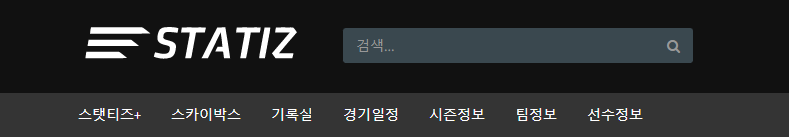
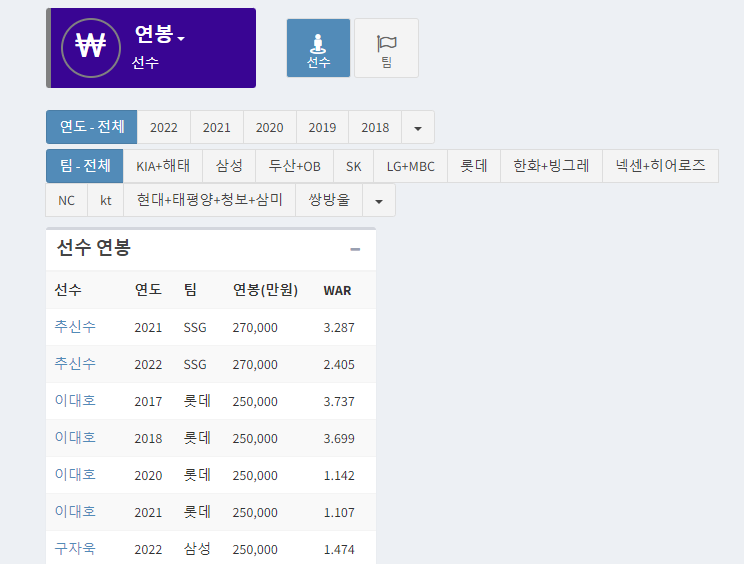

In [3]:
# pd.read_html()을 사용하여 연봉 데이터 수집
salary = pd.DataFrame(columns = ['선수', '연도', '팀', '연봉(만원)', 'WAR'])

for year in range(1983, 2021):
    for team in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 101, 102]:
        url = f'http://www.statiz.co.kr/salary.php?opt=0&sopt={year}&cnv=&pos=&te={team}'
        year_salary = pd.read_html(url)[1]
        salary = pd.concat([salary, year_salary])

In [4]:
salary

,선수,연도,팀,연봉(만원),WAR
0,이강철,1997,해태,11000,4.247
1,김정수,1997,해태,9600,1.364
2,홍현우,1997,해태,9600,5.778
3,이대진,1997,해태,9000,4.891
4,이호성,1997,해태,7000,3.295
...,...,...,...,...,...
79,신용승,2020,kt,0,NaN
80,여도건,2020,kt,0,NaN
81,김민섭,2020,kt,0,NaN
82,김경민,2020,kt,0,NaN


In [5]:
salary.columns = ['선수명', '기록년도', '팀명', '연봉(만원)', 'WAR']
salary

,선수명,기록년도,팀명,연봉(만원),WAR
0,이강철,1997,해태,11000,4.247
1,김정수,1997,해태,9600,1.364
2,홍현우,1997,해태,9600,5.778
3,이대진,1997,해태,9000,4.891
4,이호성,1997,해태,7000,3.295
...,...,...,...,...,...
79,신용승,2020,kt,0,NaN
80,여도건,2020,kt,0,NaN
81,김민섭,2020,kt,0,NaN
82,김경민,2020,kt,0,NaN


In [6]:
salary.to_csv('../data/salary_1983_to_2020.csv', encoding = 'euc-kr')

In [7]:
df3 = pd.read_csv('../data/salary_1983_to_2020.csv', encoding = 'euc-kr', index_col = 0)
df3.head()

,선수명,기록년도,팀명,연봉(만원),WAR
0,이강철,1997,해태,11000,4.247
1,김정수,1997,해태,9600,1.364
2,홍현우,1997,해태,9600,5.778
3,이대진,1997,해태,9000,4.891
4,이호성,1997,해태,7000,3.295


---

# Ⅱ. 데이터 전처리

## 1. KBREPORT

In [28]:
# 1983 - 1988 데이터 중 불필요한 컬럼 제거
df1 = df1[['#', '기록년도', '선수명','팀명', '승', '패', '세', '경기', '선발',
           '이닝', '삼진/9', '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼',
           '피안타율', '피출루율', '타자', '삼진', 'WAR', 'BABIP', 'LOB%',
           'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP', '플레이어 id']]
df1 = pd.DataFrame(df1)
df1.head(2)

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,삼진,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id
0,1,1983,장명부,삼미,30,16,6,60,51,427.3,...,220,11.4,0.279,77.0,2.34,11.45,2.37,2.43,1.16,2233
1,2,1983,이상윤,해태,20,10,6,46,35,229.3,...,178,6.8,0.265,74.1,2.67,4.37,2.06,2.38,1.20,2139


In [29]:
# 2015 - 2020 데이터 중 불필요한 컬럼 제거
df2 = df2[['#', '기록년도', '선수명', '팀명', '승', '패', '세', '경기', '선발',
           '이닝', '삼진/9', '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼',
           '피안타율', '피출루율', '타자', '삼진', 'WAR', 'BABIP', 'LOB%',
           'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP', '플레이어 id']]
df2 = pd.DataFrame(df2)
df2.head(2)

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,삼진,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id
0,1,2015,소사,LG,10,12,0,32,30,194.1,...,177,7.18,0.327,63.4,4.03,5.57,3.50,3.29,1.21,115
1,2,2015,밴헤켄,Hero,15,8,0,32,32,196.2,...,193,6.35,0.328,69.6,3.62,6.13,3.60,3.41,1.31,210


In [30]:
# 1983 - 1988 데이터와 2015 - 2020 데이터 합치기
pitcher_all_df = pd.concat([df1, df2])
pitcher_all_df.tail(2)

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,삼진,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id
2181,282,2020,최성영,NC,2,4,0,14,13,60.2,...,27,-0.78,0.271,69.1,6.08,0.14,7.33,7.71,1.68,1423
2182,283,2020,이형범,두산,1,2,1,27,0,25.2,...,13,-0.89,0.294,63.4,7.71,-0.31,6.94,7.27,1.79,813


In [31]:
len(pitcher_all_df)

2635

In [32]:
# 중복 데이터 제거
pitcher_all_df = pitcher_all_df.drop_duplicates()
pitcher_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1999
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #        1985 non-null   int64  
 1   기록년도     1985 non-null   int64  
 2   선수명      1985 non-null   object 
 3   팀명       1985 non-null   object 
 4   승        1985 non-null   int64  
 5   패        1985 non-null   int64  
 6   세        1985 non-null   int64  
 7   경기       1985 non-null   int64  
 8   선발       1985 non-null   int64  
 9   이닝       1985 non-null   float64
 10  삼진/9     1985 non-null   object 
 11  볼넷/9     1985 non-null   object 
 12  홈런/9     1985 non-null   object 
 13  삼진%      1985 non-null   float64
 14  볼넷%      1985 non-null   float64
 15  삼/볼      1985 non-null   object 
 16  피안타율     1985 non-null   object 
 17  피출루율     1985 non-null   float64
 18  타자       1985 non-null   int64  
 19  삼진       1985 non-null   int64  
 20  WAR      1985 non-null   float64
 21  BABIP    1985 

In [33]:
# 연도별 개수 확인
pitcher_all_df['기록년도'].value_counts(sort = False)

1983     55
1984     59
1985     69
1986     89
1987     88
1988     92
2015    244
2016    250
2017    239
2018    260
2019    257
2020    283
Name: 기록년도, dtype: int64

In [35]:
# 기록년도, 선수명, 팀명 기준 중복 데이터 확인
ck1 = pitcher_all_df[['기록년도', '선수명', '팀명', '플레이어 id']].value_counts()
ck1

기록년도  선수명  팀명    플레이어 id
1983  감사용  삼미    1499       1
2018  양창섭  삼성    1544       1
      유재유  두산    1435       1
      유원상  NC    288        1
      유승철  KIA   1548       1
                           ..
2015  조무근  KT    1277       1
      정회찬  Hero  263        1
      정찬헌  LG    290        1
      정재훈  롯데    620        1
2020  황인준  KIA   1580       1
Length: 1985, dtype: int64

In [36]:
ck2 = ck1[ck1 >= 2]
ck2

Series([], dtype: int64)

- 중복 데이터가 모두 제거된 것을 확인할 수 있다.

In [37]:
# 데이터 저장
pitcher_all_df.to_csv('../data/pitcher_all.csv', encoding = 'euc-kr')

In [9]:
# 데이터 확인
pitcher_all = pd.read_csv('../data/pitcher_all.csv', encoding = 'euc-kr', index_col = 0)
pitcher_all.tail()

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,삼진,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id
1995,279,2020,조영건,Hero,3,3,0,20,10,44.1,...,23,-0.52,0.271,71.9,5.28,0.23,6.89,7.24,1.67,1696
1996,280,2020,임규빈,Hero,2,0,0,33,0,37.2,...,20,-0.54,0.299,89.2,4.54,0.52,7.25,7.42,1.49,1732
1997,281,2020,박진태,KIA,0,0,0,12,0,18.2,...,14,-0.57,0.371,63.5,13.02,-0.74,11.54,11.96,2.57,1487
1998,282,2020,최성영,NC,2,4,0,14,13,60.2,...,27,-0.78,0.271,69.1,6.08,0.14,7.33,7.71,1.68,1423
1999,283,2020,이형범,두산,1,2,1,27,0,25.2,...,13,-0.89,0.294,63.4,7.71,-0.31,6.94,7.27,1.79,813


## 2. KBREPORT 데이터에 연봉 데이터 합치기

In [ ]:
for data in range(len(df3)):
    data = list(df3.loc[data])
    pitcher_all_df.loc[(pitcher_all_df["선수명"] == data[0]) & (pitcher_all_df["기록년도"] == data[1]), pitcher_all_df["연봉"]] = data[3]

In [ ]:
pitcher_all[pitcher_all['연봉'] != 0]

In [10]:
pitcher_all_with_salary = pd.merge(pitcher_all, df3, how = 'left', on = ['선수명', '기록년도'])
pitcher_all_with_salary.head()

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,팀명_y,연봉(만원),WAR_y
0,1,1983,장명부,삼미,30,16,6,60,51,427.3,...,77.0,2.34,11.45,2.37,2.43,1.16,2233,NaN,NaN,NaN
1,2,1983,이상윤,해태,20,10,6,46,35,229.3,...,74.1,2.67,4.37,2.06,2.38,1.2,2139,NaN,NaN,NaN
2,3,1983,김시진,삼성,17,12,1,37,27,229.3,...,76.7,2.55,5.26,2.3,2.53,1.24,1651,NaN,NaN,NaN
3,4,1983,최동원,롯데,9,16,4,38,29,208.7,...,72.5,2.89,2.45,2.29,2.53,1.21,2366,NaN,NaN,NaN
4,5,1983,이길환,MBC,15,7,4,33,21,208.3,...,76.3,2.51,5.23,2.72,2.68,1.15,2112,NaN,NaN,NaN


In [14]:
pitcher_all_with_salary = pitcher_all_with_salary.drop(['팀명_y', 'WAR_y'], axis = 1)
pitcher_all_with_salary.head(2)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원)
0,1,1983,장명부,삼미,30,16,6,60,51,427.3,...,11.4,0.279,77.0,2.34,11.45,2.37,2.43,1.16,2233,NaN
1,2,1983,이상윤,해태,20,10,6,46,35,229.3,...,6.8,0.265,74.1,2.67,4.37,2.06,2.38,1.2,2139,NaN


In [15]:
pitcher_all_with_salary.to_csv('../data/pitcher_all_with_salary.csv', encoding = 'euc-kr')

In [17]:
pitcher_all_with_salary = pd.read_csv('../data/pitcher_all_with_salary.csv', encoding = 'euc-kr', index_col = 0)
pitcher_all_with_salary.tail(2)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원)
2046,282,2020,최성영,NC,2,4,0,14,13,60.2,...,-0.78,0.271,69.1,6.08,0.14,7.33,7.71,1.68,1423,9500.0
2047,283,2020,이형범,두산,1,2,1,27,0,25.2,...,-0.89,0.294,63.4,7.71,-0.31,6.94,7.27,1.79,813,14200.0


In [20]:
# 최동원 선수 연봉 정보 직접 입력
# 참고: https://sports.news.naver.com/news?oid=295&aid=0000001174

pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1983), '연봉(만원)'] = 3000.0
pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1984), '연봉(만원)'] = 3000.0
pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1985), '연봉(만원)'] = 7400.0
pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1986), '연봉(만원)'] = 8100.0
pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1987), '연봉(만원)'] = 8910.0
pitcher_all_with_salary.loc[(pitcher_all_with_salary['선수명'] == '최동원') & (pitcher_all_with_salary['기록년도'] == 1988), '연봉(만원)'] = 8910.0

In [21]:
# 잘 입력되었는지 확인
pitcher_all_with_salary[pitcher_all_with_salary['선수명'] == '최동원']

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원)
3,4,1983,최동원,롯데,9,16,4,38,29,208.7,...,5.43,0.297,72.5,2.89,2.45,2.29,2.53,1.21,2366,3000.0
55,1,1984,최동원,롯데,27,13,6,51,42,284.7,...,8.43,0.267,77.0,2.4,6.18,1.99,2.25,1.04,2366,3000.0
114,1,1985,최동원,롯데,20,9,8,42,35,225.0,...,9.43,0.257,76.0,1.92,7.33,1.56,1.79,0.94,2366,7400.0
184,2,1986,최동원,롯데,19,14,2,39,21,267.0,...,11.84,0.268,80.3,1.55,9.01,1.2,1.49,0.97,2366,8100.0
272,1,1987,최동원,롯데,14,12,2,32,25,224.0,...,8.14,0.318,74.2,2.81,4.78,1.96,2.24,1.25,2366,8910.0
362,3,1988,최동원,롯데,7,3,3,16,4,83.3,...,3.73,0.317,80.9,2.05,2.51,1.48,2.0,1.21,2366,8910.0


In [23]:
pitcher_all_with_salary.to_csv('../data/pitcher_all_with_salary_include_choi.csv', encoding = 'euc-kr')

In [24]:
pitcher_all_with_salary_include_choi = pd.read_csv('../data/pitcher_all_with_salary_include_choi.csv', encoding = 'euc-kr', index_col = 0)
pitcher_all_with_salary_include_choi.head(2)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원)
0,1,1983,장명부,삼미,30,16,6,60,51,427.3,...,11.4,0.279,77.0,2.34,11.45,2.37,2.43,1.16,2233,NaN
1,2,1983,이상윤,해태,20,10,6,46,35,229.3,...,6.8,0.265,74.1,2.67,4.37,2.06,2.38,1.2,2139,NaN


---

# Ⅲ. 데이터 매핑

- 1980년대 최동원이 활동하던 투수들의 연봉 및 데이터를 2010년대 투수들의 연봉 및 데이터로 매핑(mapping)하는, 즉 변환하는 문제가 있을 것
- 이 문제를 효과적으로 해결
- 최동원의 데이터만 현재 선수에 맞춰 변환할 것인지, 또는 당시 선수들의 데이터를 모두 변환해서 검토할 것인지 결정 필요

소비자 물가 지수를 고려해서 연봉 데이터를 매핑하고자 한다.
<br>비교시점을 2020년으로 해서 1983년 ~ 2019년까지의 연봉을 모두 2020년의 화폐가치로 변환하고자 한다.
<br>다음은 통계청 > 화폐가치 계산(https://kostat.go.kr/incomeNcpi/cpi/cpi_ep/2/index.action?bmode=pay) 을 참고한 물가상승 배수이다.
<br>
<br>- 1983년 → 2020년 : 3.546 배
<br>- 1984년 → 2020년 : 3.467 배
<br>- 1985년 → 2020년 : 3.384 배
<br>- 1986년 → 2020년 : 3.293 배
<br>- 1987년 → 2020년 : 3.196 배
<br>- 1988년 → 2020년 : 2.982 배
<br>- 2015년 → 2020년 : 1.054 배
<br>- 2016년 → 2020년 : 1.044 배
<br>- 2017년 → 2020년 : 1.024 배
<br>- 2018년 → 2020년 : 1.009 배
<br>- 2019년 → 2020년 : 1.005 배
<br>
<br>따라서 2020년을 제외한 나머지 연도에 물가상승 배수를 곱하여 2020년도 기준의 연봉으로 변환하고자 하며, 우선 연봉 결측을 제거하고자 한다.

In [14]:
pitcher_all_with_salary_include_choi.head(3)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원)
0,1,1983,장명부,삼미,30,16,6,60,51,427.3,...,11.40,0.279,77.0,2.34,11.45,2.37,2.43,1.16,2233,NaN
1,2,1983,이상윤,해태,20,10,6,46,35,229.3,...,6.80,0.265,74.1,2.67,4.37,2.06,2.38,1.2,2139,NaN
2,3,1983,김시진,삼성,17,12,1,37,27,229.3,...,5.99,0.272,76.7,2.55,5.26,2.3,2.53,1.24,1651,NaN


In [15]:
# 결측 확인 (count)
pitcher_all_with_salary_include_choi.isnull().sum()

#            0
기록년도         0
선수명          0
팀명_x         0
승            0
패            0
세            0
경기           0
선발           0
이닝           0
삼진/9         0
볼넷/9         0
홈런/9         0
삼진%          0
볼넷%          0
삼/볼          0
피안타율         0
피출루율         0
타자           0
삼진           0
WAR_x        0
BABIP        0
LOB%         0
ERA          0
RA9-WAR      0
FIP          0
kFIP         0
WHIP         0
플레이어 id      0
연봉(만원)     757
dtype: int64

In [16]:
# 연봉 데이터 없는 (NaN) 선수(row) 제거
df_fin = pitcher_all_with_salary_include_choi.dropna(axis = 0)

print(len(df_fin))
df_fin.isnull().sum()

1291


#          0
기록년도       0
선수명        0
팀명_x       0
승          0
패          0
세          0
경기         0
선발         0
이닝         0
삼진/9       0
볼넷/9       0
홈런/9       0
삼진%        0
볼넷%        0
삼/볼        0
피안타율       0
피출루율       0
타자         0
삼진         0
WAR_x      0
BABIP      0
LOB%       0
ERA        0
RA9-WAR    0
FIP        0
kFIP       0
WHIP       0
플레이어 id    0
연봉(만원)     0
dtype: int64

In [17]:
# 연봉이 0인 선수(row) 제거
df_fin = df_fin[df_fin['연봉(만원)'] > 0]
len(df_fin)

1160

- 본 프로젝트는 연봉 정보가 중요하기 때문에 연봉 정보가 있는 선수들만을 가지고 모델링하고자 한다.
- 따라서 연봉 데이터가 없는 선수와 0원으로 기재된 선수를 제거하여, 총 1160명이 남게 되었다.
<br>
<br>
- 이제 연봉 데이터를 2020년 기준으로 매핑(변환)하고자 한다.

In [23]:
multiple_inflation = []

for row in df_fin['기록년도']:
    if row == 1983:
        multiple_inflation.append(float(3.546))
    elif row == 1984:
        multiple_inflation.append(float(3.467))
    elif row == 1985:
        multiple_inflation.append(float(3.384))
    elif row == 1986:
        multiple_inflation.append(float(3.293))
    elif row == 1987:
        multiple_inflation.append(float(3.196))
    elif row == 1988:
        multiple_inflation.append(float(2.982))
    elif row == 2015:
        multiple_inflation.append(float(1.054))
    elif row == 2016:
        multiple_inflation.append(float(1.044))
    elif row == 2017:
        multiple_inflation.append(float(1.024))
    elif row == 2018:
        multiple_inflation.append(float(1.009))
    elif row == 2019:
        multiple_inflation.append(float(1.005))
    else:
        multiple_inflation.append(float(1.000))

df_fin['물가상승배수'] = multiple_inflation
df_fin.head()

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원),물가상승배수
3,4,1983,최동원,롯데,9,16,4,38,29,208.7,...,0.297,72.5,2.89,2.45,2.29,2.53,1.21,2366,3000.0,3.546
55,1,1984,최동원,롯데,27,13,6,51,42,284.7,...,0.267,77.0,2.4,6.18,1.99,2.25,1.04,2366,3000.0,3.467
114,1,1985,최동원,롯데,20,9,8,42,35,225.0,...,0.257,76.0,1.92,7.33,1.56,1.79,0.94,2366,7400.0,3.384
184,2,1986,최동원,롯데,19,14,2,39,21,267.0,...,0.268,80.3,1.55,9.01,1.2,1.49,0.97,2366,8100.0,3.293
272,1,1987,최동원,롯데,14,12,2,32,25,224.0,...,0.318,74.2,2.81,4.78,1.96,2.24,1.25,2366,8910.0,3.196


In [24]:
df_fin['연봉(만원)_new'] = df_fin['연봉(만원)'] * df_fin['물가상승배수']
df_fin.head(3)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원),물가상승배수,연봉(만원)_new
3,4,1983,최동원,롯데,9,16,4,38,29,208.7,...,72.5,2.89,2.45,2.29,2.53,1.21,2366,3000.0,3.546,10638.0
55,1,1984,최동원,롯데,27,13,6,51,42,284.7,...,77.0,2.4,6.18,1.99,2.25,1.04,2366,3000.0,3.467,10401.0
114,1,1985,최동원,롯데,20,9,8,42,35,225.0,...,76.0,1.92,7.33,1.56,1.79,0.94,2366,7400.0,3.384,25041.6


In [25]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 3 to 2047
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #           1160 non-null   int64  
 1   기록년도        1160 non-null   int64  
 2   선수명         1160 non-null   object 
 3   팀명_x        1160 non-null   object 
 4   승           1160 non-null   int64  
 5   패           1160 non-null   int64  
 6   세           1160 non-null   int64  
 7   경기          1160 non-null   int64  
 8   선발          1160 non-null   int64  
 9   이닝          1160 non-null   float64
 10  삼진/9        1160 non-null   object 
 11  볼넷/9        1160 non-null   object 
 12  홈런/9        1160 non-null   object 
 13  삼진%         1160 non-null   float64
 14  볼넷%         1160 non-null   float64
 15  삼/볼         1160 non-null   object 
 16  피안타율        1160 non-null   object 
 17  피출루율        1160 non-null   float64
 18  타자          1160 non-null   int64  
 19  삼진          1160 non-null  

In [26]:
df_fin.to_csv('../data/pitcher_final.csv', encoding = 'euc-kr')

In [27]:
pitcher_final = pd.read_csv('../data/pitcher_final.csv', encoding = 'euc-kr', index_col = 0)
pitcher_final.tail(2)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원),물가상승배수,연봉(만원)_new
2046,282,2020,최성영,NC,2,4,0,14,13,60.2,...,69.1,6.08,0.14,7.33,7.71,1.68,1423,9500.0,1.0,9500.0
2047,283,2020,이형범,두산,1,2,1,27,0,25.2,...,63.4,7.71,-0.31,6.94,7.27,1.79,813,14200.0,1.0,14200.0


In [28]:
len(pitcher_final)

1160

---

# Ⅳ. 최동원 선수의 연봉 예측

- 2번의 데이터를 기준으로 최동원의 성적이라면 연봉이 어떨지 예측

## 1. 데이터 타입 변환

In [2]:
pitcher_final = pd.read_csv('../data/pitcher_final.csv', encoding = 'euc-kr', index_col = 0)
pitcher_final.tail(2)

,#,기록년도,선수명,팀명_x,승,패,세,경기,선발,이닝,...,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉(만원),물가상승배수,연봉(만원)_new
2046,282,2020,최성영,NC,2,4,0,14,13,60.2,...,69.1,6.08,0.14,7.33,7.71,1.68,1423,9500.0,1.0,9500.0
2047,283,2020,이형범,두산,1,2,1,27,0,25.2,...,63.4,7.71,-0.31,6.94,7.27,1.79,813,14200.0,1.0,14200.0


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False

f_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family = font_name)

- 연봉 예측을 수행하기 전 object 변수를 float로 변환하고자 한다.

In [4]:
for col in ['삼진/9', '볼넷/9', '홈런/9', '삼/볼', '피안타율', 'BABIP',
            'LOB%', 'ERA', 'FIP', 'kFIP', 'WHIP']:
    pitcher_final.loc[pitcher_final[col] == '-', col] = 0
    pitcher_final[col] = pitcher_final[col].astype(float)

pitcher_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 3 to 2047
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #           1160 non-null   int64  
 1   기록년도        1160 non-null   int64  
 2   선수명         1160 non-null   object 
 3   팀명_x        1160 non-null   object 
 4   승           1160 non-null   int64  
 5   패           1160 non-null   int64  
 6   세           1160 non-null   int64  
 7   경기          1160 non-null   int64  
 8   선발          1160 non-null   int64  
 9   이닝          1160 non-null   float64
 10  삼진/9        1160 non-null   float64
 11  볼넷/9        1160 non-null   float64
 12  홈런/9        1160 non-null   float64
 13  삼진%         1160 non-null   float64
 14  볼넷%         1160 non-null   float64
 15  삼/볼         1160 non-null   float64
 16  피안타율        1160 non-null   float64
 17  피출루율        1160 non-null   float64
 18  타자          1160 non-null   int64  
 19  삼진          1160 non-null  

## 2. 변수 탐색 - features, target

#### Correlation (y: 연봉(만원)_new / x: 나머지)

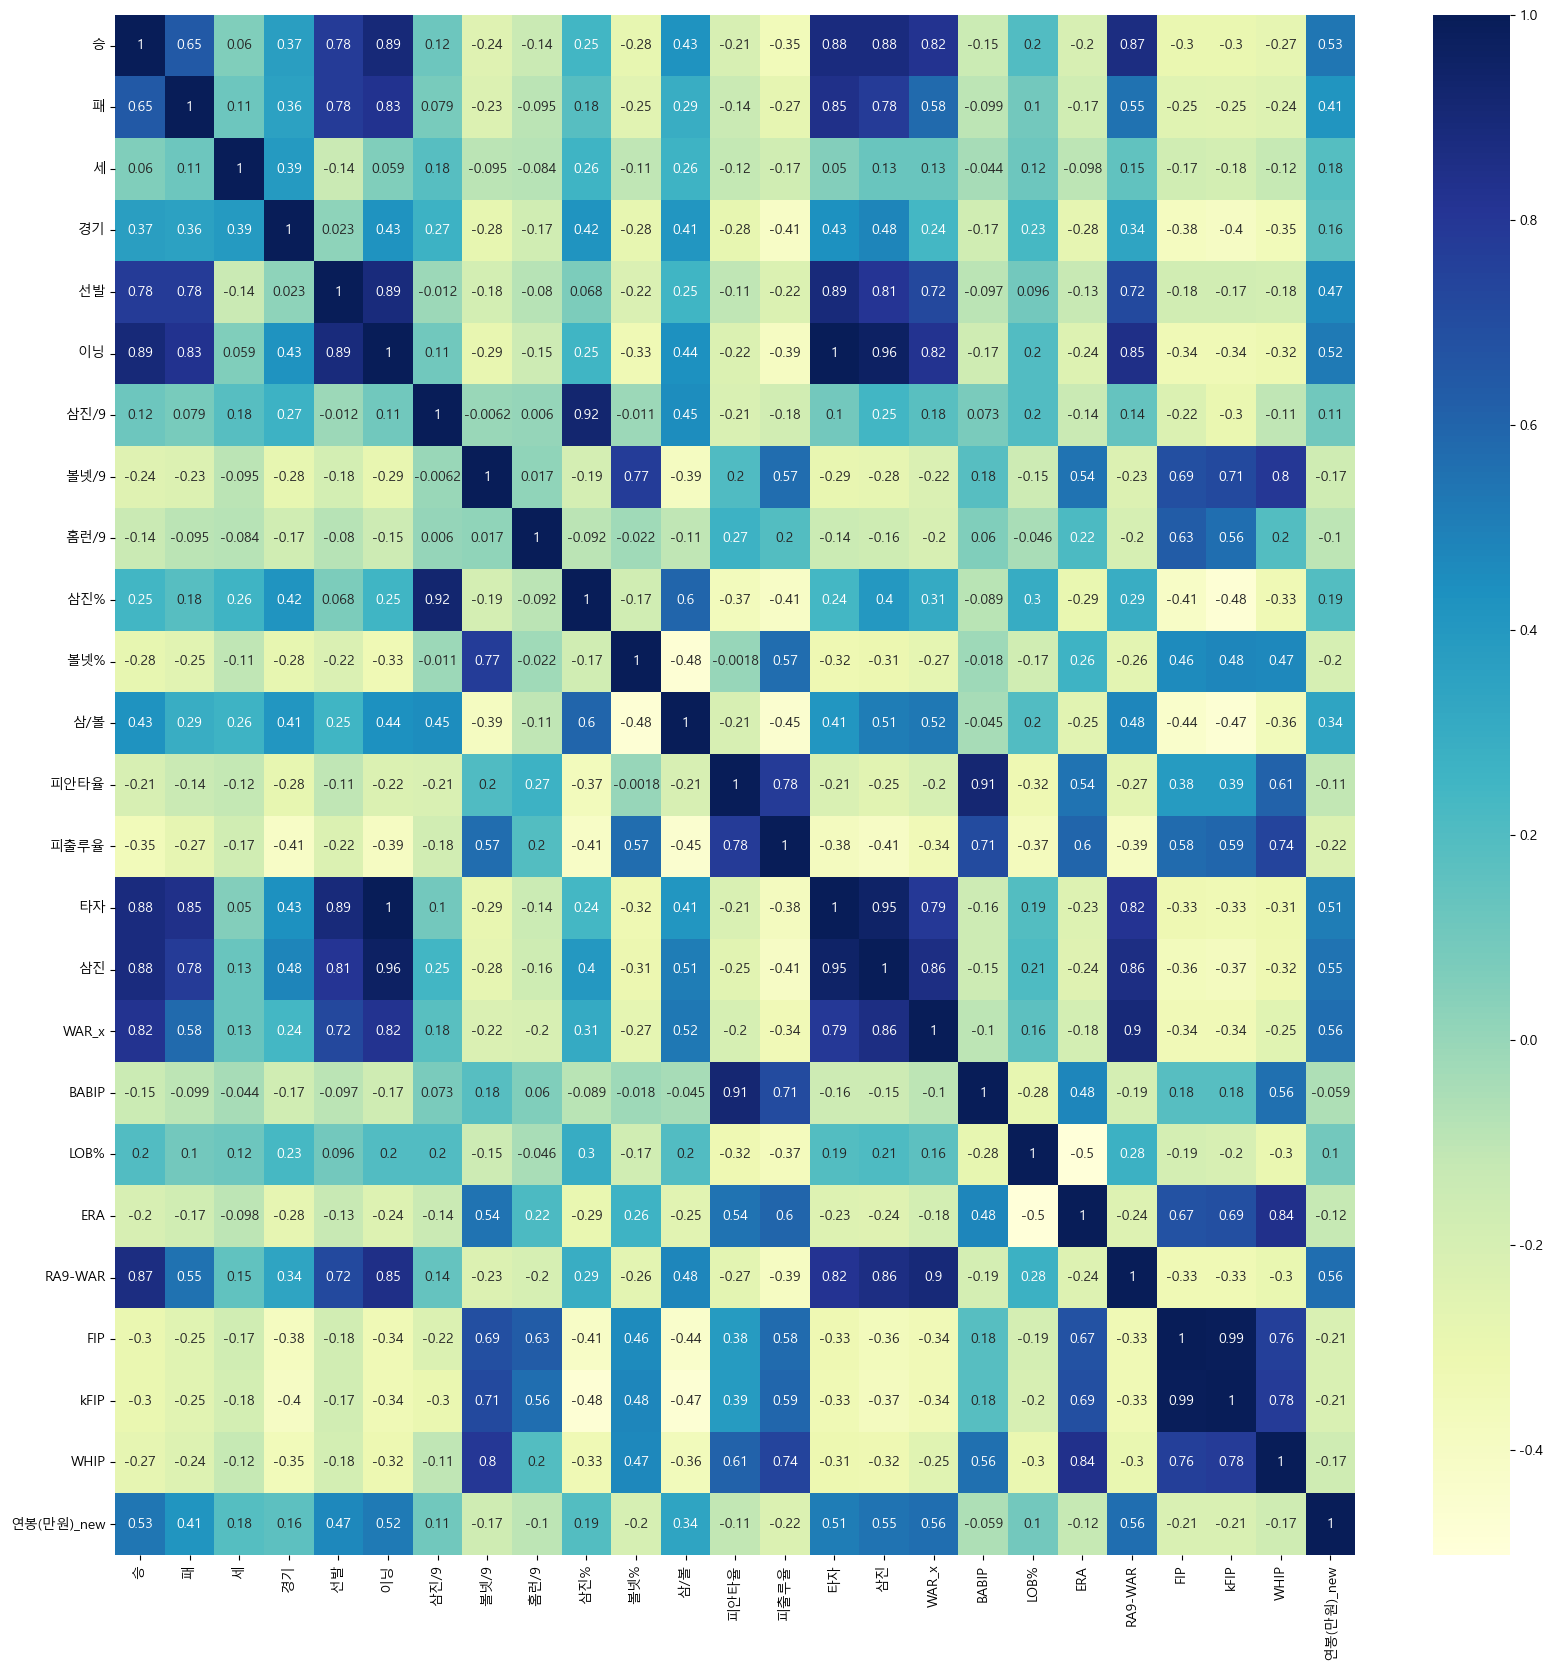

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr_df = pitcher_final[['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
                 '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율',
                 '피출루율', '타자', '삼진', 'WAR_x', 'BABIP', 'LOB%', 'ERA',
                 'RA9-WAR', 'FIP', 'kFIP', 'WHIP', '연봉(만원)_new']]

plt.figure(figsize = (20, 20))
sns.heatmap(corr_df.corr(), cmap = 'YlGnBu', annot = True)
plt.show();

In [6]:
# features data
feature_df = pitcher_final[['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
                            '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼',
                            '피안타율', '피출루율', '타자', '삼진', 'WAR_x',
                            'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP',
                            'WHIP']]
feature_df.head(2)

,승,패,세,경기,선발,이닝,삼진/9,볼넷/9,홈런/9,삼진%,...,타자,삼진,WAR_x,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP
3,9,16,4,38,29,208.7,6.38,2.20,0.73,17.1,...,863,148,5.43,0.297,72.5,2.89,2.45,2.29,2.53,1.21
55,27,13,6,51,42,284.7,7.05,2.15,0.57,19.7,...,1132,223,8.43,0.267,77.0,2.40,6.18,1.99,2.25,1.04


#### x와 y의 histogram

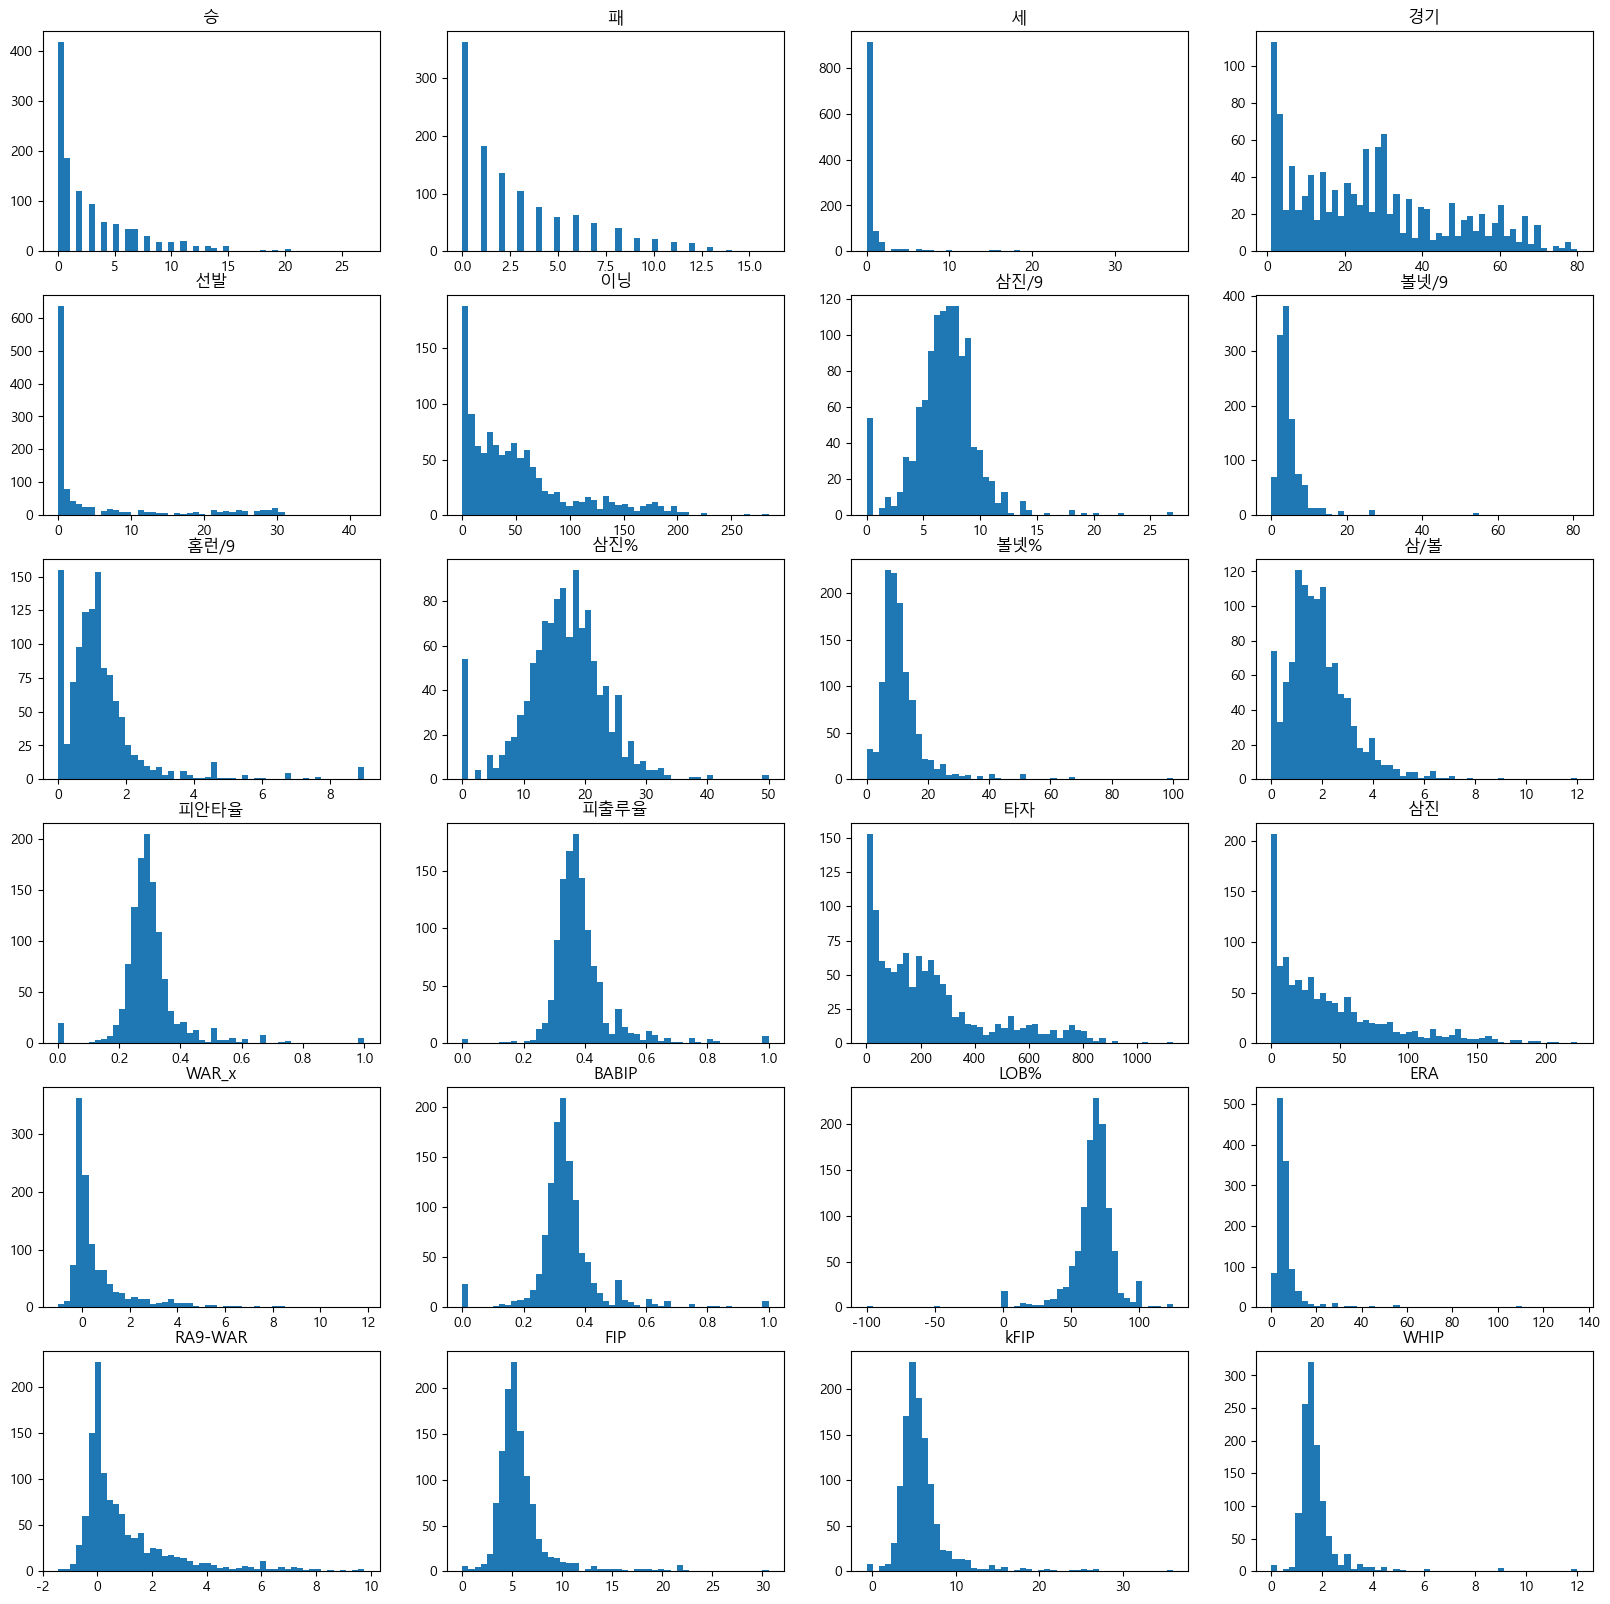

In [7]:
# 피처 각각에 대한 histogram
def draw_hist(df):
    plt.rcParams['figure.figsize'] = [20, 20]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(6, 4, i + 1)
        plt.hist(df[df.columns[i]], bins = 50)
        ax.set_title(df.columns[i])
    plt.show()

draw_hist(feature_df)

In [8]:
# target data
target_df = pitcher_final[['연봉(만원)_new']]
target_df.head(2)

,연봉(만원)_new
3,10638.0
55,10401.0


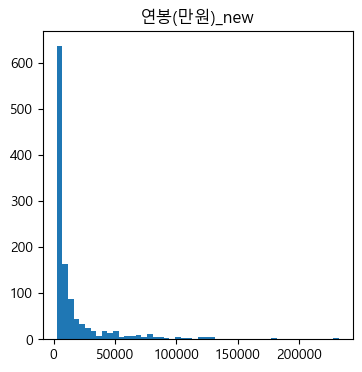

In [9]:
plt.figure(figsize = (4, 4))
plt.hist(target_df['연봉(만원)_new'], bins = 50)
plt.title('연봉(만원)_new')
plt.show()

- 히스토그램을 통해 스케일링이 필요하다고 판단된다.
- 정규분포 형태에 가깝게 하기 위해 Standard Scaler를 사용하고자 한다.
- 스케일링 과정은 pipeline을 통해 진행하고자 한다.

## 3. model 적합

### (1) Full model

### Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split

X = pitcher_final[['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
                   '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율',
                   '피출루율', '타자', '삼진', 'WAR_x', 'BABIP', 'LOB%',
                   'ERA', 'RA9-WAR', 'FIP', 'kFIP','WHIP']]
y = pitcher_final['연봉(만원)_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((928, 24), (232, 24), (928,), (232,))

#### 모델 적합

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

estimators = [('sclaer', StandardScaler()),
              ('clf', LinearRegression())]

pipe_lr1 = Pipeline(estimators)
pipe_lr1.fit(X_train, y_train)
pred1 = pipe_lr1.predict(X_test)

#### 지표 확인

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error

pred_tr1 = pipe_lr1.predict(X_train)
pred_test1 = pipe_lr1.predict(X_test)

rmse_tr1 = (np.sqrt(mean_squared_error(y_train, pred_tr1)))
rmse_test1 = (np.sqrt(mean_squared_error(y_test, pred_test1)))

print('RMSE of Train Data : ', rmse_tr1)
print('RMSE of Test Data : ', rmse_test1)

RMSE of Train Data :  22000.649883021197
RMSE of Test Data :  20819.457613962666


In [15]:
from sklearn.metrics import r2_score as r2

r2(y_test, pred_test1)

0.40584999265229715

### (2) correlation -0.2 ~ 0.2인 features 제거

- 앞서 수행했던 상관분석(heatmap) 참고
- '연봉(만원)_new'와의 correlation이 -0.2와 0.2 사이인 feature는 제거하고 분석을 수행하고자 한다. (상관성이 매우 낮기 때문)
- 따라서 최종적으로 분석에 사용되는 feature는 아래 12개로 선정하여 다시 회귀분석을 수행하고자 한다.
<br>['승', '패', '선발', '이닝', '삼/볼', '피출루율', '타자', '삼진', 'WAR_x', 'RA9-WAR', 'FIP', 'kFIP']

### Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = pitcher_final[['승', '패', '선발', '이닝', '삼/볼', '피출루율', '타자', '삼진', 'WAR_x', 'RA9-WAR', 'FIP', 'kFIP']]
y = pitcher_final['연봉(만원)_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((928, 12), (232, 12), (928,), (232,))

#### 모델 적합

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

estimators = [('sclaer', StandardScaler()),
              ('clf', LinearRegression())]

pipe_lr2 = Pipeline(estimators)
pipe_lr2.fit(X_train, y_train)
pred2 = pipe_lr2.predict(X_test)

#### 지표 확인

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

pred_tr2 = pipe_lr2.predict(X_train)
pred_test2 = pipe_lr2.predict(X_test)

rmse_tr2 = (np.sqrt(mean_squared_error(y_train, pred_tr2)))
rmse_test2 = (np.sqrt(mean_squared_error(y_test, pred_test2)))

print('RMSE of Train Data : ', rmse_tr2)
print('RMSE of Test Data : ', rmse_test2)

RMSE of Train Data :  22381.81523175174
RMSE of Test Data :  20670.88595276054


In [19]:
from sklearn.metrics import r2_score as r2

r2(y_test, pred_test2)

0.4142996732935077

### (3) correlation -0.3 ~ 0.3인 features 제거

- '연봉(만원)_new'와의 correlation이 -0.3와 0.3사이인 feature는 제거하고 분석을 수행하고자 한다. (상관성이 매우 낮기 때문)
- 따라서 최종적으로 분석에 사용되는 feature는 아래 9개로 재선정하여 다시 회귀분석을 수행하고자 한다.
<br>['승', '패', '선발', '이닝', '삼/볼', '타자', '삼진', 'WAR_x', 'RA9-WAR']

### Train/Test Split

In [77]:
from sklearn.model_selection import train_test_split

X = pitcher_final[['승', '패', '선발', '이닝', '삼/볼', '타자', '삼진', 'WAR_x', 'RA9-WAR']]
y = pitcher_final['연봉(만원)_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((928, 9), (232, 9), (928,), (232,))

### 모델 적합

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

estimators = [('sclaer', StandardScaler()),
              ('clf', LinearRegression())]

pipe_lr3 = Pipeline(estimators)
pipe_lr3.fit(X_train, y_train)
pred3 = pipe_lr3.predict(X_test)

### 지표 확인

In [79]:
import numpy as np
from sklearn.metrics import mean_squared_error

pred_tr3 = pipe_lr3.predict(X_train)
pred_test3 = pipe_lr3.predict(X_test)

rmse_tr3 = (np.sqrt(mean_squared_error(y_train, pred_tr3)))
rmse_test3 = (np.sqrt(mean_squared_error(y_test, pred_test3)))

print('RMSE of Train Data : ', rmse_tr3)
print('RMSE of Test Data : ', rmse_test3)

RMSE of Train Data :  22366.022027907744
RMSE of Test Data :  20818.312942015524


In [80]:
from sklearn.metrics import r2_score as r2

r2(y_test, pred_test3)

0.4449165636462269

## 4. 모델 비교

1. model 1: full model
2. model 2: 상관계수 ±0.2 사이 features 제거 후 모델링
3. model 3: 상관계수 ±0.3 사이 features 제거 후 모델링

|model no.|RMSE of train data|RMSE of test data|r2|
|---|---|---|---|
|model 1|22000.650|20819.458|0.406|
|model 2|22381.815|20670.886|0.414|
|model 3|22366.022|20818.313|0.449|

- model 별 train data와 test data의 RMSE 차이는 각각 '1,181.192', '1,710.929', '1,547.709'이고
- 모델 설명력 (r2)을 참고하면 model 3의 설명력이 약 45%로 가장 높다.
- 모든 모델의 설명력은 50%도 채 되지 않는 것으로 보아, 설명력은 낮다고 할 수 있다.
- 그러나 train data와 test data의 RMSE 차이가 가장 작고, 설명력이 가장 높은 것을 만족하는 모델은 model 3이므로 최종 모델은 model 3으로 결정하였다.

## 5. 연봉 예측하기

In [81]:
# 연봉을 예측하여 데이터프레임의 컬럼 생성
X = pitcher_final[['승', '패', '선발', '이닝', '삼/볼',
                   '타자', '삼진', 'WAR_x', 'RA9-WAR']]
pred_salary = pipe_lr3.predict(X)
pitcher_final['예측 연봉'] = pd.Series(pred_salary)

In [83]:
result_df = pitcher_final[['기록년도', '선수명', '팀명_x', '승',
                           '패', '선발', '이닝', '삼/볼', '타자',
                           '삼진', 'WAR_x', 'RA9-WAR', '연봉(만원)',
                           '연봉(만원)_new', '예측 연봉']]
result_df.head(2)

,기록년도,선수명,팀명_x,승,패,선발,이닝,삼/볼,타자,삼진,WAR_x,RA9-WAR,연봉(만원),연봉(만원)_new,예측 연봉
3,1983,최동원,롯데,9,16,29,208.7,2.90,863,148,5.43,2.45,3000.0,10638.0,88460.529665
55,1984,최동원,롯데,27,13,42,284.7,3.28,1132,223,8.43,6.18,3000.0,10401.0,27640.319974


In [85]:
result_choi = result_df[result_df['선수명'] == '최동원']
result_choi

,기록년도,선수명,팀명_x,승,패,선발,이닝,삼/볼,타자,삼진,WAR_x,RA9-WAR,연봉(만원),연봉(만원)_new,예측 연봉
3,1983,최동원,롯데,9,16,29,208.7,2.90,863,148,5.43,2.45,3000.0,10638.00,88460.529665
55,1984,최동원,롯데,27,13,42,284.7,3.28,1132,223,8.43,6.18,3000.0,10401.00,27640.319974
114,1985,최동원,롯데,20,9,35,225.0,3.93,865,161,9.43,7.33,7400.0,25041.60,15155.585792
184,1986,최동원,롯데,19,14,21,267.0,3.78,1039,208,11.84,9.01,8100.0,26673.30,8792.122374
272,1987,최동원,롯데,14,12,25,224.0,2.67,920,163,8.14,4.78,8910.0,28476.36,17448.418327
362,1988,최동원,롯데,7,3,4,83.3,3.46,349,83,3.73,2.51,8910.0,26569.62,9855.722657


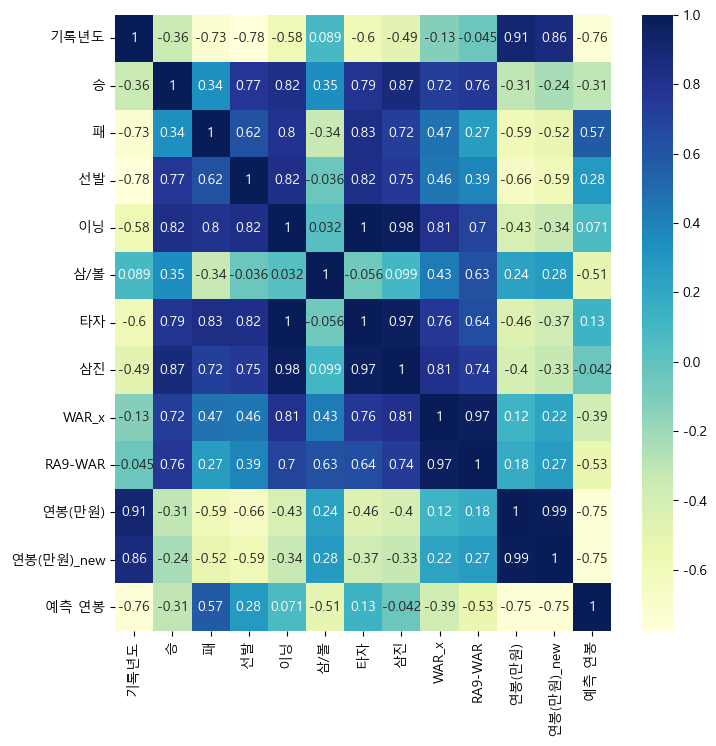

In [86]:
plt.figure(figsize = (8, 8))
sns.heatmap(result_choi.corr(), cmap = 'YlGnBu', annot = True)
plt.show();

- 예측 연봉은 승, 패, 삼/볼, WAR, RA9-WAR과 상관성이 높은 것을 확인할 수 있었고, 이를 바탕으로 연봉이 예측된 것을 알 수 있다.
<br>
<br>
- 최동원 선수의 동결되기 전 최대 연봉은 1987년 8,910 만원이다.
<br>
<br>
- **이 연도를 바탕으로 최동원 선수가 2020년에 프로야구 선수로 활동했다면 약 17,448 만원의 연봉을 받았을 것이라고 예측된다.**

In [87]:
result_choi[result_choi['기록년도'] == 1987]

,기록년도,선수명,팀명_x,승,패,선발,이닝,삼/볼,타자,삼진,WAR_x,RA9-WAR,연봉(만원),연봉(만원)_new,예측 연봉
272,1987,최동원,롯데,14,12,25,224.0,2.67,920,163,8.14,4.78,8910.0,28476.36,17448.418327
